# Key points for ML classifier analysis

- Most of this code depends on the specific input files for RNA and clinical data so it may need modification
- Repeat this same sequence of steps for each individual outcome (gait, urinary, coginitive) to generate the plots in Figure 6/Supplementary Figure 4
- Plots can be further edited in Adobe or similar software to replicate published figures

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import matplotlib as mpl

mpl.rc('font',family='Arial')

#use matplotlib inline if widget not installed in conda environment
%matplotlib widget 

In [10]:
#read in a df contained normalized gene expression and clinical information
rna = pd.read_csv('/Users/zachlevin/Desktop/Neuroscience/Fleischmann Lab/NPH/THESIS/DATA/14k_vst_norm_genes_2022.csv')

clinical = pd.read_csv('/Users/zachlevin/Desktop/Neuroscience/Fleischmann Lab/NPH/master_clinical/april2022/NPH_master_clinical_4.2.22.csv',skiprows=2).set_index('Subject or Animal ID')



In [11]:
# column name of the clinical outcome to be analyzed
clin_variable = 'sx_improve_urinary'

# Preprocessing and Preparing RNA and Clinical Data

In [12]:
#Samples 22 and 46 are not used in any analysis so they are removed from any RNA/clinical files

def preproc_rna(rna_df):
    """
    Preprocesses the rna dataframe by
    transposing it and renaming the columns
    """
    rna_copy = rna_df.copy(deep=True)
    
    #Rename RNA dataframe columns and then transpose
    col_list = rna_copy.columns.values.tolist()
    col_list[0] = 'gene_name'
    rna_copy.columns = col_list
    rna_copy = rna_copy.T
    
    #Make the columns the gene names and then drop that first row containing gene symbols
    rna_copy.columns = rna_copy.iloc[0]
    rna_copy = rna_copy.drop(['gene_name'])
    rna_copy.index.rename('sample',inplace=True)
    
    rna_copy = rna_copy.drop(labels = "CSF-022",axis=0)
    return rna_copy

def preproc_clinical(clin_df):
    """
    Preprocesses the clinical dataframe by
    removing CSF-046 (non-NPH sample)
    """
    clin_copy = clin_df.copy(deep=True)
    if clin_copy.iloc[41].name == 'CSF-046':
        clin_copy = clin_copy.drop(labels = 'CSF-046', axis=0)
        print("CSF-046 dropped")
    if clinical.iloc[18].name == 'CSF-022':
        clin_copy = clin_copy.drop(labels = 'CSF-022', axis=0)
        print("CSF-022 dropped")
    return clin_copy


In [13]:
#Functions for removing samples missing clinical data from a master clinical data frame
def get_NAs(column):
    """Get indices of samples with missing data"""
    remove = []
    for i in range(len(column)):
        if column[i] == 'NOT_APPLICABLE':
            remove.append(i)
    return remove

def remove_NAs(X,y,NA):
    """Remove samples with missing clinical data from rna and clinical dataframes"""
    X_clean = X.drop(X.index[NA],axis=0)
    y_clean = y.drop(y.index[NA],axis=0)
    return X_clean, y_clean

In [14]:
processed_clin = preproc_clinical(clinical)

processed_rna = preproc_rna(rna)

#check that rna and clinical indices match each other
processed_rna.index.to_list() == processed_clin.index.to_list()

CSF-046 dropped
CSF-022 dropped


True

In [15]:
#filter out samples from both dataframes if those samples are missing the clinical outcome
filtered_rna, filtered_clinical = remove_NAs(processed_rna,processed_clin,
                                             get_NAs(processed_clin[clin_variable]))

#check that rna and clinical indices (sample orders) still match each other
filtered_rna.index.to_list() == filtered_clinical.index.to_list()

True

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, RocCurveDisplay, auc, f1_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn import set_config


# Make num genes panel

In [11]:
#create a list that contains the number of selected genes to be tested
num_genes = []

for i in range(10,160,10): # 10 - 150 in increments of 10
    num_genes.append(i)

for i in range(200,1100,100): # 200 - 1000 in increments of 100
    num_genes.append(i)

In [12]:

X = filtered_rna
y = filtered_clinical[clin_variable]

aucs = [] # list to store aucs calculated with each number of selected features


for num_feats in num_genes: #iterate through the list of genes to be selected
    true = []
    predictions = []
    
    for train_idx, test_idx in LeaveOneOut().split(X,y):

        clf = Pipeline([('scaler',StandardScaler()), 
                    ('select_from_model',SelectFromModel(LogisticRegression(max_iter = 250),
                                                         max_features=num_feats)),
                    ('SVM',SVC(C=1,probability = True,random_state=1001))])

        x_train = X.iloc[train_idx]
        x_test = X.iloc[test_idx]

        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]

        clf.fit(x_train,y_train)
        pos_prediction = clf.predict_proba(x_test)[:,1] #probability predicition of sample being pos. class

        true.append(y_test.tolist()[0])

        predictions.append(pos_prediction.tolist()[0])
    
    aucs.append(metrics.roc_auc_score(true,predictions))

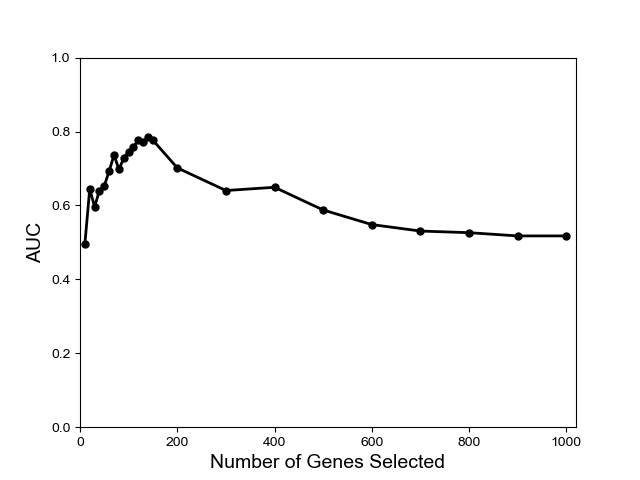

In [13]:
#create a plot that shows how AUC varies based on number of genes selected
plt.scatter(num_genes,aucs,s=25,c='black')
plt.plot(num_genes,aucs,lw=2,c='black')
plt.xlabel('Number of Genes Selected',fontsize=14)
plt.ylabel('AUC',fontsize=14)
plt.ylim(0,1)
plt.xlim(0,1020)
plt.show()



In [13]:
plt.savefig('sx_improve_cog_num_genes.pdf',bbox_inches = 'tight',dpi=300)

In [19]:
plt.close('all')

In [14]:
max(aucs)

0.7850877192982456

In [15]:
print("The smallest number of selected genes that give the max AUC is: " + str(num_genes[aucs.index(max(aucs))]))

The smallest number of selected genes that give the max AUC is: 140


In [17]:
rna = filtered_rna
y = filtered_clinical[clin_variable] #clinical outcome of interest


rna_prob_predictions = [] #Probability predictions for each tested sample being in positive class
rna_bin_predictions = [] #Thresholded label predictions for test samples (threshold = .5 probability)

true = []

features = []


for train_idx, test_idx in LeaveOneOut().split(rna,y):
    
    clf_rna = Pipeline([('scaler',StandardScaler()), 
                    ('select_from_model',SelectFromModel(LogisticRegression(max_iter = 250),
                                                         max_features=140)),
                    ('SVM',SVC(C=1,probability = True,random_state=1001))])

    
    rna_train = rna.iloc[train_idx]
    rna_test = rna.iloc[test_idx]
    
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    
    clf_rna.fit(rna_train,y_train)
    rna_pos_prediction = clf_rna.predict_proba(rna_test)[:,1]
    rna_bin_prediction = clf_rna.predict(rna_test)

    true.append(y_test.tolist()[0])
    
    rna_prob_predictions.append(rna_pos_prediction.tolist()[0])
    rna_bin_predictions.append(rna_bin_prediction.tolist()[0])

    
    #this appends the names of genes selected in each fold for later inspection and PCA
    selected_feats = [i for (i, v) in zip(rna.columns.to_list(), clf_rna.named_steps['select_from_model'].get_support()) if v]
    features.append(selected_feats)

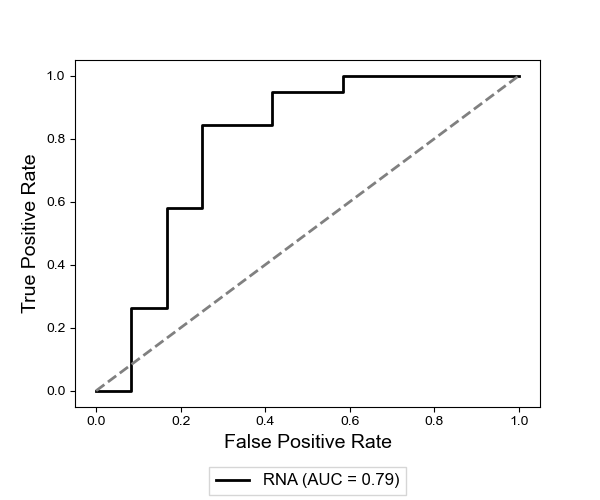

In [19]:
# plot ROC curve

fig,axs = plt.subplots()
fig.set_size_inches(6,5)


true = [int(i) for i in true]
binned = [int(i) for i in rna_bin_predictions]

RocCurveDisplay.from_predictions(true,rna_prob_predictions,ax=axs,color='black',lw=2,name='RNA',linestyle='-')

box = axs.get_position()
axs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

axs.set_xlabel('False Positive Rate',fontsize='14')
axs.set_ylabel('True Positive Rate',fontsize='14')    
    
axs.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")



# Put a legend below current axis
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=False, shadow=False, ncol=5,fontsize='12')


In [30]:
plt.savefig('sx_improve_cog_ROC.pdf',bbox_inches = 'tight',dpi=300)

In [18]:
plt.close()

In [19]:
unique_feats = []
for l in features:
    unique_feats.extend(l)

with open('urinary_imp_unique_genes.txt', 'w') as f:
    for item in set(unique_feats):
        f.write("%s\n" % item)

In [20]:
def count_genes(feat_list):
    genes = {}
    for gene_list in feat_list:
        for gene in gene_list:
            if gene not in genes:
                genes[gene] = 1
            else:
                genes[gene] +=1
    return genes

def get_top_genes(feat_dict): 
    return sorted(feat_dict, key=feat_dict.get, reverse=True)

    

In [21]:
filtered_clinical.shape

(31, 32)

In [22]:
gene_count = count_genes(features)
top_genes = get_top_genes(gene_count)

In [23]:
counts = [gene_count.get(key) for key in top_genes]

In [24]:
gene_df = pd.DataFrame({"gene": top_genes,
             "counts": counts})

In [25]:
genes_in_all_folds = gene_df.loc[gene_df["counts"] == 31]

In [26]:
genes_in_all_folds = genes_in_all_folds["gene"].to_list()

# Make PCA panel

In [28]:
filtered_clinical.loc[["CSF-005","CSF-043","CSF-045"]]

Gender  Age    BMI nph_category sx_cognition  \
Subject or Animal ID                                                
CSF-005                   M   83  29.39            1            1   
CSF-043                   F   80  24.87            1            0   
CSF-045                   M   71  30.10            1            1   

                     sx_cognition_dur sx_urinary sx_urinary_dur sx_gait  \
Subject or Animal ID                                                      
CSF-005                             0          1              1       1   
CSF-043                NOT_APPLICABLE          1              1       1   
CSF-045                             0          1              0       1   

                     sx_gait_dur  ...  symptoms_post___7  symptoms_post___9  \
Subject or Animal ID              ...                                         
CSF-005                        1  ...                  0                  0   
CSF-043                        1  ...                  0                  1   
CSF-045                        0  ...                  0                  0   

                      ambulation_post  sx_resolution_all  sx_improve_cog  \
Subject or Animal ID                                                       
CSF-005                             3                  0               0   
CSF-043                NOT_APPLICABLE                  0  NOT_APPLICABLE   
CSF-045                NOT_APPLICABLE                  0               0   

                      sx_improve_urinary  sx_improve_gait preop_mrs 3M_mrs  \
Subject or Animal ID                                                         
CSF-005                                0                0         4      4   
CSF-043                                0                1         2      2   
CSF-045                                0                0         2      2   

                     mrs_improved  
Subject or Animal ID               
CSF-005                         0  
CSF-043                         0  
CSF-045                         0  

[3 rows x 32 columns]

In [30]:

pca = PCA(n_components = .9)

#fit PCA to the training samples expression of the genes selected in fold 1
train_pca_coords = pd.DataFrame(pca.fit_transform(filtered_rna[features[0]].iloc[1:]))

#apply that PCA to the test sample
test_pca_coords = pd.DataFrame(pca.transform(pd.DataFrame(filtered_rna[features[0]].iloc[:1])))



In [31]:

#use the clinical dataframe to set the PCA dataframe rows to their sample names
train_pca_coords['sample'] = filtered_clinical.iloc[1:].index
train_pca_coords = train_pca_coords.set_index('sample')

test_pca_coords['sample'] = filtered_clinical.iloc[:1].index
test_pca_coords = test_pca_coords.set_index('sample')



#identify which samples are 1s and which are 0s in the clinical dataframe
train_improved = filtered_clinical.iloc[1:].loc[filtered_clinical[1:][clin_variable] == '1']
train_not_improved = filtered_clinical.iloc[1:].loc[filtered_clinical[1:][clin_variable] == '0']

#subset the PCA dataframe into separate tables for improved and not improved samples
train_pca_improved = train_pca_coords.loc[train_pca_coords.index.isin(train_improved.index)]
train_pca_not_improved = train_pca_coords.loc[train_pca_coords.index.isin(train_not_improved.index)]



#repeat for the test sample
test_improved = filtered_clinical.iloc[:1].loc[filtered_clinical[:1][clin_variable] == '1']
test_not_improved = filtered_clinical.iloc[:1].loc[filtered_clinical[:1][clin_variable] == '0']

test_pca_improved = test_pca_coords.loc[test_pca_coords.index.isin(test_improved.index)]
test_pca_not_improved = test_pca_coords.loc[test_pca_coords.index.isin(test_not_improved.index)]




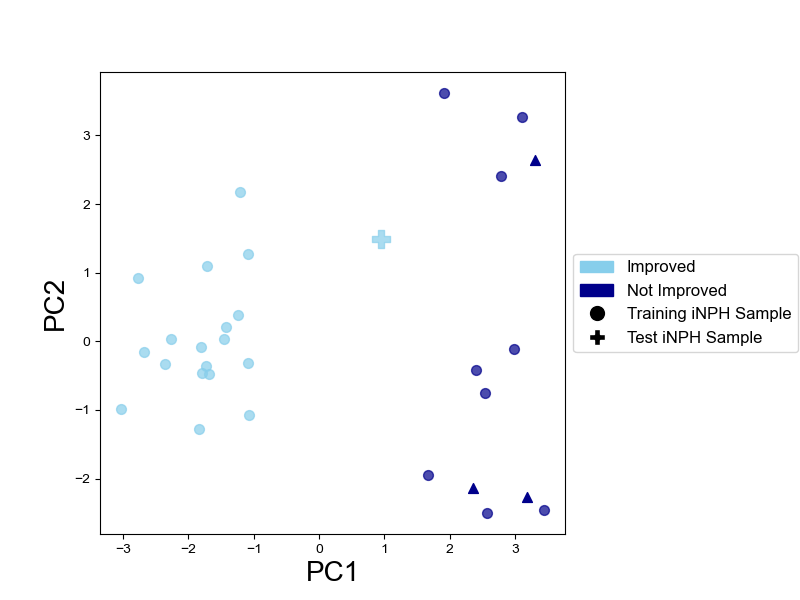

In [32]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 

#ax.set_title('PCA of samples based on top 60 genes',fontsize=20)
ax.set_xlabel('PC1',fontsize=20)
ax.set_ylabel('PC2',fontsize=20)

#If plotting sNPH and iNPH patients, these lines account for different marker shapes
#Double check where these three patients fall (improved/not improved) for each outcome to avoid errors

#Plot the sNPH as triangles first
ax.scatter(train_pca_not_improved[0]["CSF-005"],train_pca_not_improved[1]["CSF-005"],s=50,c='darkblue',marker='^')
ax.scatter(train_pca_not_improved[0]["CSF-045"],train_pca_not_improved[1]["CSF-045"],s=50,c='darkblue',marker='^')
ax.scatter(train_pca_not_improved[0]["CSF-043"],train_pca_not_improved[1]["CSF-043"],s=50,c='darkblue',marker='^')

#Remove sNPH samples (already plotted above)
train_pca_not_improved = train_pca_not_improved.drop(labels=["CSF-005","CSF-045","CSF-043"])
#train_pca_improved = train_pca_not_improved.drop(labels = ["CSF-043"])

#Plot iNPH samples and test sample
ax.scatter(train_pca_improved[0],train_pca_improved[1],c='skyblue',s=50,label='Improved',alpha =.7)
ax.scatter(train_pca_not_improved[0],train_pca_not_improved[1],c='darkblue',s=50,label = 'Not Improved',alpha =.7)

ax.scatter(test_pca_improved[0],test_pca_improved[1],c='skyblue',s=150,label = 'Test Improved',marker='P',alpha =.7)
ax.scatter(test_pca_not_improved[0],test_pca_not_improved[1],c='darkblue',s=150,label = 'Test Not Improved',marker='P',alpha =.7)





box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

legend_elements = [Patch(facecolor='skyblue', edgecolor='skyblue',
                         label='Improved'),
                  Patch(facecolor='darkblue', edgecolor='darkblue',
                         label='Not Improved'),
                   Line2D([0], [0], marker='o', color='w', label='Training iNPH Sample',
                          markerfacecolor='black', markersize=12),
                   #Line2D([0], [0], marker='^', color='w', label='Training sNPH Sample',
                   #       markerfacecolor='black', markersize=12),
                   Line2D([0], [0], marker='P', color='w', label='Test iNPH Sample',
                          markerfacecolor='black', markersize=12)
                  ]

ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
         fancybox=True,fontsize='12')

plt.show()



In [26]:
plt.savefig('sx_improve_urinary_PCA.svg',bbox_inches = 'tight',dpi=300)

In [37]:
plt.close()